In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [2]:
planet = 'b'
paths = sorted(glob('trappist1_Spitzer_Michael/T1{0}/LCs/ch1*'.format(planet)))

from robin import TransitParams
params = TransitParams()
params.per = 1.51087637
params.t0 =  7322.51654 #2450000 +
params.inc = 89.56
params.a = 20.56
params.rp = params.p0 = params.p1 = (0.7266/100)**0.5
params.duration = 36.19/60/24
params.b = 0.157
params.u = [1.00, -0.04]
params.limb_dark = 'quadratic'
params.w = 0
params.ecc = 0

In [3]:
import astropy.units as u
from astropy.constants import R_sun, M_sun, G, R_earth, M_earth

rho_sun = M_sun / (4/3 * np.pi * R_sun**3)

rho_star = 47.00335066 * rho_sun
rho_star_upper = (rho_star + 4.2*rho_sun)

R_star = 0.1210 * R_sun
ars = float((rho_star * G * (params.per * u.day)**2 / 3 / np.pi)**(1/3))
ars_upper = float((rho_star_upper * G * (params.per * u.day)**2 / 3 / np.pi)**(1/3))
ars_err = ars_upper - ars
ars, ars_err

(19.997084540980982, 0.5787063286409762)

In [4]:
import numpy as np

all_ttvs = []

for planet in list('bcdefgh'):
    rows = []
    for line in open('trappist1_Spitzer_Michael/T1{0}/MCMC_1/mcmc_med.res'.format(planet)).read().splitlines():
        if line.strip().startswith('Ttr'):
#         if line.strip().startswith('TTV'):
            #rows.append(list(map(float, line.split()[2:-2])))
            rows.append(list(map(float, line.split()[2:-2])))
    ttvs = np.array(rows)[:, 0]
    all_ttvs.append(ttvs)

In [5]:
ttvs = all_ttvs[0]
bjd, flux, err, x, y, fwhm, fwhmx, fwhmy, bg, airmass, exptime = np.loadtxt(paths[0], unpack=True)
ttv = ttvs[np.argmin(np.abs(bjd.mean() - ttvs))]

In [6]:
ttv

7809.0183439499997

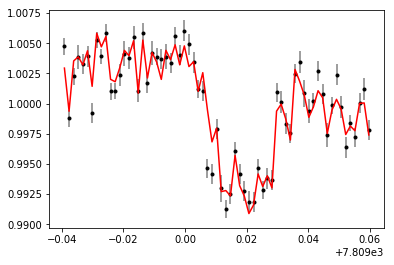

In [7]:
import emcee
import robin
from copy import deepcopy

measured_u1 = 0.17151765
measured_u1_err = 0.019
measured_u2 = 0.24481933
measured_u2_err = 0.02

def transit_model(theta, x):
    #f0, t0, c1, c2, c3, c4 = theta
    t0, = theta
    trial_params = deepcopy(params)
    trial_params.t0 = t0    
    m = robin.TransitModel(trial_params, x, exp_time=1.92/60/60/24, supersample_factor=3)
    fluxes = m.light_curve(trial_params)
    return fluxes

def regress_model(theta): 
#     f0, t0, c1, c2, c3, c4 = theta
    c1, c2, c3, c4 = theta

    return c1*x + c2*y + c3*fwhmx + c4 * fwhmy

init_f = transit_model([params.t0], bjd)

X_all = np.vstack([init_f, x, y, fwhmx, fwhmy]).T
X = X_all[:, :]

omega = np.diag(err**2)
omega_inv = np.linalg.inv(omega)

V = np.linalg.inv(X.T @ omega_inv @ X)
beta = V @ X.T @ omega_inv @ flux

beta = beta.tolist()

init_p = [ttv] + beta[1:] #, 0.0, 0.0, 0.0, 0.0]

regressed_lc = (X_all @ beta) 

plt.errorbar(bjd, flux, err, fmt='.', color='k', ecolor='gray')
# plt.plot(bjd, regress_model(init_p) + 1)
plt.plot(bjd, regressed_lc, 'r', zorder=10)

In [8]:
import celerite
from celerite import terms
from celerite.modeling import Model

class MeanModel(Model):
    parameter_names = ['t0', 'c1', 'c2', 'c3', 'c4']

    def get_value(self, t):
        trial_params = deepcopy(params)
        trial_params.t0 = self.t0
        return transit_model([self.t0], t) + regress_model([self.c1, self.c2, self.c3, self.c4])

initp_dict = dict(t0=params.t0, c1=beta[1], c2=beta[2], c3=beta[3], c4=beta[4])

parameter_bounds = dict(t0=[params.t0-0.02, params.t0+0.02], 
                        c1=[-10, 10], c2=[-10, 10], c3=[-10, 10], c4=[-10, 10])

mean_model = MeanModel(bounds=parameter_bounds, **initp_dict)

#kernel = terms.RealTerm(log_a=np.var(flux), log_c=-np.log(10.0))

#bounds = dict(log_sigma=(0, 5), log_rho=(-15, 15)) # Finds solution w/o crashing but a weird one
bounds = dict(log_sigma=(-15, -5), log_rho=(np.log(0.01), 15))

kernel = terms.Matern32Term(log_sigma=-6, log_rho=np.log(0.1), bounds=bounds)

# Q = 1.0 / np.sqrt(2.0)
# log_w0 = np.log(2*np.pi/(8/24))
# log_S0 = -15

# bounds = dict(log_S0=(-30, 15), log_Q=(-15, 15),
#               log_omega0=(-1000, 1000))

# kernel = terms.SHOTerm(log_S0=log_S0, log_Q=np.log(Q),
#                        log_omega0=log_w0, bounds=bounds)

gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
gp.compute(bjd, err)

In [9]:
# def lnlike(theta, x, y, yerr):
#     f0, t0, c1, c2, c3, c4 = theta

#     model = transit_model(theta, x) 
#     return -0.5*(np.sum((model + regress_model(theta) - y)**2 / yerr**2))

# def lnprior(theta):
#     f0, t0, c1, c2, c3, c4 = theta

#     if (0 < f0 < 1.5 and -10 < c1 < 10 and -10 < c2 < 10 and -10 < c3 < 10 and -10 < c4 < 10 and bjd.min() < t0 < bjd.max()):
#         return 0
#     return -np.inf

# def lnprob(theta, x, y, yerr):
#     lp = lnprior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + lnlike(theta, x, y, yerr)


def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
#     lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(flux) + lp

ndim, nwalkers = 7, 14

pos = []

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                threads=8)

In [10]:
initial_params = gp.get_parameter_vector()

In [11]:
pos = []
while len(pos) < nwalkers: 
    trial_pos = np.array(initial_params) + 1e-6*np.random.randn(len(initial_params))
    #if np.isfinite(lnprior(trial_pos)):
    pos.append(trial_pos)

In [12]:
p0 = sampler.run_mcmc(pos, 10000)

In [13]:
samples = sampler.chain[:, -1000:, :].reshape((-1, ndim))

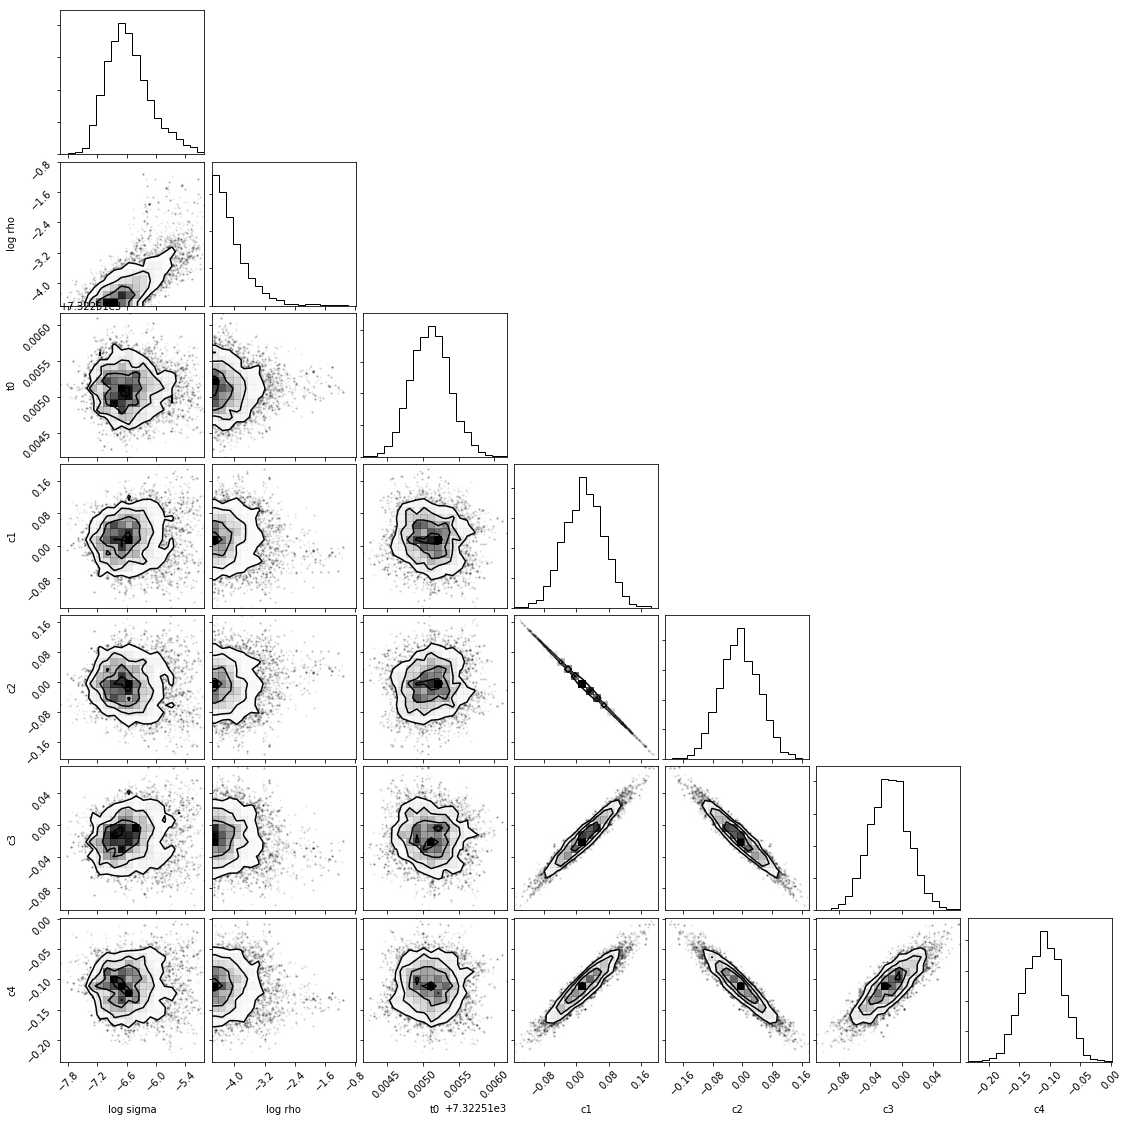

In [14]:
from corner import corner

corner(samples, labels='log sigma, log rho, t0, c1, c2, c3, c4'.split(', '))
plt.show()

In [15]:
best_params = sampler.flatchain[np.argmax(sampler.flatlnprobability), :]

In [16]:
best_params

array([ -7.02980375e+00,  -4.52629980e+00,   7.32251508e+03,
         1.99801121e-02,  -9.14878618e-03,  -1.40812793e-02,
        -1.09240353e-01])

In [22]:
best_params[2:3]

array([ 7322.51507584])

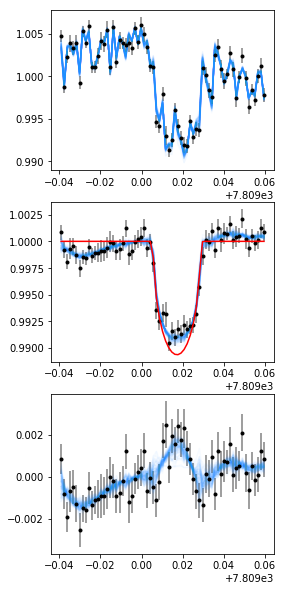

In [29]:
#best_f = regress_model(best_params[-4:]) + transit_model(best_params[3:5], bjd)   #-regress_model(best_params) + 2

fig, ax = plt.subplots(3, 1, figsize=(4, 10))
ax[0].errorbar(bjd, flux, err, fmt='.', color='k', ecolor='gray')
# ax[0].plot(bjd, best_f, 'r', zorder=10)
for s in samples[np.random.randint(len(samples), size=100)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(flux, bjd, return_cov=False)
    ax[0].plot(bjd, mu, color='DodgerBlue', alpha=0.03)

# ax[0].set_ylim([0.98, 1.01])
    
ax[1].errorbar(bjd, flux - regress_model(best_params[-4:]), err, fmt='.', color='k', ecolor='gray')
ax[1].plot(bjd, transit_model(best_params[2:3], bjd) , 'r', zorder=10)

for s in samples[np.random.randint(len(samples), size=100)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(flux, bjd, return_cov=False)
    ax[1].plot(bjd, mu - regress_model(best_params[-4:]), color='DodgerBlue', alpha=0.03)
    
    
ax[2].errorbar(bjd, flux -  regress_model(best_params[-4:]) - transit_model(best_params[2:3], bjd), err, fmt='.', color='k', ecolor='gray')

for s in samples[np.random.randint(len(samples), size=100)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(flux, bjd, return_cov=False)
    ax[2].plot(bjd, mu - regress_model(best_params[-4:]) - transit_model(best_params[2:3], bjd), color='DodgerBlue', alpha=0.03)
    